In [1]:
# first neural network with keras tutorial
import pandas as pd
import pandas_ta as ta
import random
from collections import deque
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten, Activation, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint, Callback, TensorBoard, LearningRateScheduler
import time
import statistics
from sklearn import preprocessing
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os.path
from numpy import loadtxt
import yfinance as yf
import math
pd.options.mode.chained_assignment = None  # default='warn'

In [28]:
## getting data ##
def getDF(ticker):
    # Load data
    df = pd.read_csv('BTC-USD_1hour.csv')
    df = df.drop(columns=['Unnamed: 0'])
    df = df.tail(900)
    
    # add data points
    df['close_per1'] = df.ta.percent_return(length=1, close = df['close'])*100
    df['close_per3'] = df.ta.percent_return(length=3, close = df['close'])*100
    df['ema10'] = df.ta.ema(length=10, close = df['close'])
    df['ema3'] = df.ta.ema(length=3, close = df['close'])
    df['rsi7'] = df.ta.rsi(length=7, close = df['close'])/100
    df['rsi14'] = df.ta.rsi(length=14, close = df['close'])/100
    df['williams7'] = df.ta.willr(length=7, close = df['close'])/100
    df['williams14'] = df.ta.willr(length=14, close = df['close'])/100
    

#     del df['timestamp']
    del df['trades']
    del df['volume']
    
    df = df.dropna()
    df.reset_index(inplace=True)
    
    return df

In [29]:
ticker = "TNA"
df = getDF(ticker)
df.tail(10)

,index,timestamp,open,high,low,close,close_per1,close_per3,ema10,ema3,rsi7,rsi14,williams7,williams14
876,1991,"03/05/2022, 13:00:00",39451.57,39460.58,39279.71,39408.51,-0.109146,0.563365,39260.679512,39383.502900,0.626787,0.442559,-0.287808,-0.246401
877,1992,"03/05/2022, 14:00:00",39408.51,39464.24,39370.90,39442.63,0.086580,0.143935,39293.761419,39413.066450,0.648304,0.454241,-0.235549,-0.209987
878,1993,"03/05/2022, 15:00:00",39442.63,39587.54,39406.84,39490.61,0.121645,0.098957,39329.552070,39451.838225,0.678694,0.471028,-0.166843,-0.144474
879,1994,"03/05/2022, 16:00:00",39490.61,39549.14,39369.34,39372.15,-0.299970,-0.092264,39337.297148,39411.994112,0.543433,0.435417,-0.434632,-0.306221
880,1995,"03/05/2022, 17:00:00",39372.15,39479.10,39290.98,39466.30,0.239128,0.060011,39360.752212,39439.147056,0.614645,0.469731,-0.293804,-0.177667
881,1996,"03/05/2022, 18:00:00",39466.30,39468.30,39337.11,39407.02,-0.150204,-0.211671,39369.164537,39423.083528,0.551462,0.451139,-0.586428,-0.258609
882,1997,"03/05/2022, 19:00:00",39407.02,39611.31,39361.85,39602.27,0.495470,0.584474,39411.547349,39512.676764,0.678469,0.518709,-0.027262,-0.013537
883,1998,"03/05/2022, 20:00:00",39602.27,39686.74,39441.29,39458.78,-0.362328,-0.019054,39420.135103,39485.728382,0.545930,0.472657,-0.576006,-0.306719
884,1999,"03/05/2022, 21:00:00",39458.78,39533.00,39383.49,39529.36,0.178870,0.310452,39439.994176,39507.544191,0.591702,0.496343,-0.397665,-0.211754
885,2000,"03/05/2022, 22:00:00",39529.36,39569.60,39284.67,39373.74,-0.393682,-0.577063,39427.947962,39440.642096,0.469865,0.448508,-0.778471,-0.432016


In [25]:
df['close_per3_shifted'] = df['close_per3'].shift(-3)
# df['open_per1_shifted'] = df['open_per1'].shift(-1)
df.tail(10)

,index,timestamp,open,high,low,close,close_per1,close_per3,ema10,ema3,rsi7,rsi14,close_per3_shifted
876,1991,"03/05/2022, 13:00:00",39451.57,39460.58,39279.71,39408.51,-0.109146,0.563365,39260.679512,39383.502900,0.626787,0.442559,-0.092264
877,1992,"03/05/2022, 14:00:00",39408.51,39464.24,39370.90,39442.63,0.086580,0.143935,39293.761419,39413.066450,0.648304,0.454241,0.060011
878,1993,"03/05/2022, 15:00:00",39442.63,39587.54,39406.84,39490.61,0.121645,0.098957,39329.552070,39451.838225,0.678694,0.471028,-0.211671
879,1994,"03/05/2022, 16:00:00",39490.61,39549.14,39369.34,39372.15,-0.299970,-0.092264,39337.297148,39411.994112,0.543433,0.435417,0.584474
880,1995,"03/05/2022, 17:00:00",39372.15,39479.10,39290.98,39466.30,0.239128,0.060011,39360.752212,39439.147056,0.614645,0.469731,-0.019054
881,1996,"03/05/2022, 18:00:00",39466.30,39468.30,39337.11,39407.02,-0.150204,-0.211671,39369.164537,39423.083528,0.551462,0.451139,0.310452
882,1997,"03/05/2022, 19:00:00",39407.02,39611.31,39361.85,39602.27,0.495470,0.584474,39411.547349,39512.676764,0.678469,0.518709,-0.577063
883,1998,"03/05/2022, 20:00:00",39602.27,39686.74,39441.29,39458.78,-0.362328,-0.019054,39420.135103,39485.728382,0.545930,0.472657,NaN
884,1999,"03/05/2022, 21:00:00",39458.78,39533.00,39383.49,39529.36,0.178870,0.310452,39439.994176,39507.544191,0.591702,0.496343,NaN
885,2000,"03/05/2022, 22:00:00",39529.36,39569.60,39284.67,39373.74,-0.393682,-0.577063,39427.947962,39440.642096,0.469865,0.448508,NaN


In [45]:
# start classifying 
def classify(df):
    std_constant = 0.65
    # handling the target data outputs (3 days)
    df['close_per3_shifted'] = df['close_per3'].shift(-3)
    df = df.dropna()
    
    value = df['close_per3_shifted'].std()*std_constant
    print("std: {}".format(round(float(value),2)))
    
    # this is the target column
    target_per = list(df['close_per3_shifted'])
    
    target = []
    for i in target_per:
        if i > value:
            target.append(2)
        elif i < -value:
            target.append(1)
        else:
            target.append(0)
    df['target'] = target
    
    
    # setting the model inputs for close to close percent change (1 days)
    value = df['close_per1'].std()*std_constant
    LIST_op1 = list(df['close_per1'])
    for i in range(len(LIST_op1)):
        if LIST_op1[i] > value:
            LIST_op1[i] = 1
        elif LIST_op1[i] < -value:
            LIST_op1[i] = -1
        else:
            LIST_op1[i] = 0
    df['O_O_percent1'] = LIST_op1
    
    
    # setting the model inputs for close to close percent change (3 days)
    value = df['close_per3'].std()*std_constant
    LIST_op3 = list(df['close_per3'])
    for i in range(len(LIST_op3)):
        if LIST_op3[i] > value:
            LIST_op3[i] = 1
        elif LIST_op3[i] < -value:
            LIST_op3[i] = -1
        else:
            LIST_op3[i] = 0
    df['O_O_percent3'] = LIST_op3
    
    

    LISTsma10 = list(df['ema10'])
    LISTsma3 = list(df['ema3'])
    for i in range(len(LISTsma10)):
        if LISTsma10[i] > df.iloc[i]['close']:
            LISTsma10[i] = 1
        else:
            LISTsma10[i] = 0
        if LISTsma3[i] > df.iloc[i]['close']:
            LISTsma3[i] = 1
        else:
            LISTsma3[i] = 0
    df['ema10'] = LISTsma10
    df['ema3'] = LISTsma3
    
    
    
    df = df.dropna()
    
    # picking out the columns I want for the model
    df = df[[
            'ema3','ema10','rsi7','rsi14','williams7','williams14','O_O_percent3','O_O_percent1','target','close_per3_shifted'
            ]]
#     # picking out the columns I want for the model
#     df = df[[
#             'ema3','ema10','rsi7','rsi14','O_O_percent3','O_O_percent1','target','close_per3_shifted'
#             ]]

    
    
    # converting the df to array
    dataset = df.to_numpy()
    
    return dataset

In [31]:
ticker = "TNA"
df = getDF(ticker)
dataset = classify(df)
# dataset.tail(5)
# dataset

std: 0.65


In [32]:
dataset[0]


array([ 1.        ,  0.        ,  0.51558522,  0.54714601, -1.        ,
       -1.        ,  1.        , -1.17232663])

In [33]:
def trainData(SEQ_LEN, SHIFT, tickers):
    Sequential_data = []
    for ticker in tickers:
        df = getDF(ticker)
        dataset = classify(df)

        dataset = dataset[0:-int(SHIFT)]
        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

        for i in dataset:  # iterate over the values
            prev_days.append([n for n in i[:-2]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!


        random.shuffle(sequential_data)  # shuffle for good measure.

        buy = []; notbuy = []; maybe = []

        for seq, target, percentage in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target, percentage])
            elif target == 1:
                notbuy.append([seq, target, percentage]) 
            elif target == 2:
                buy.append([seq, target, percentage])  

        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)

        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?

        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]

        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
        
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []; p = []
    for seq, target, percentage in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        p.append(percentage)  # y is the targets/labels (buys vs sell/notbuy)

            
    return np.array(X).astype("float64"), np.array(y).astype("uint8"), p



In [34]:
def testData(SEQ_LEN, SHIFT, tickers):
    Sequential_data = []
    for ticker in tickers:
        df = getDF(ticker)
        dataset = classify(df)

        dataset = dataset[-int(SHIFT):]
        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

        for i in dataset:  # iterate over the values
            prev_days.append([n for n in i[:-2]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!


        random.shuffle(sequential_data)  # shuffle for good measure.

        buy = []; notbuy = []; maybe = []

        for seq, target, percentage in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target, percentage])
            elif target == 1:
                notbuy.append([seq, target, percentage]) 
            elif target == 2:
                buy.append([seq, target, percentage])  

        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)

        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
        
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []; p = []
    for seq, target, percentage in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        p.append(percentage)  # y is the targets/labels (buys vs sell/notbuy)

            
    return np.array(X).astype("float64"), np.array(y).astype("uint8"), p



In [35]:
tickers = ["BTC"]
SHIFT = 200
SEQ_LEN = 3
trainX, trainY, trainPercent = trainData(SEQ_LEN, SHIFT, tickers)
validationX, validationY, validationPercent = testData(SEQ_LEN, SHIFT, tickers)
print("tickers: {}, train length: {}, validation length: {}".format(tickers, len(trainX), len(validationX)))

std: 0.65
std: 0.65
tickers: ['BTC'], train length: 426, validation length: 198


In [36]:
trainX[0][0]

array([ 1.        ,  1.        ,  0.25562867,  0.3916158 , -1.        ,
       -1.        ])

In [46]:
def main(tickers, SEQ_LEN, SHIFT):
    trainX, trainY, trainPercent = trainData(SEQ_LEN, SHIFT, tickers)
    validationX, validationY, validationPercent = testData(SEQ_LEN, SHIFT, tickers)
    print("tickers: {}, train length: {}, validation length: {}".format(tickers, len(trainX), len(validationX)))
    
    
    # SimpleRNN model
    model = Sequential()
    
    model.add(SimpleRNN(units=8, input_shape=(trainX.shape[1:]), activation="tanh", return_sequences=False))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(Dense(8, activation="tanh")) 
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(Dense(3, activation='softmax'))

    

    BATCH_SIZE = 8; EPOCHS = 1250
    
    
    # compile the keras model
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
#     opt = tf.keras.optimizers.Adam(learning_rate=0.00001, decay=1e-5)

    model.compile(
            loss='sparse_categorical_crossentropy', 
            optimizer=opt, 
            metrics=['accuracy']
        )

    # fit the keras model on the dataset
    history = model.fit(
        trainX, trainY,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(validationX, validationY),
        verbose = 0
    )
    
    predictions = (model.predict(validationX))

    # evaluate the keras model
    _, accuracy = model.evaluate(trainX, trainY, verbose=0)
    print('Accuracy with train data: %.2f' % (accuracy*100))
    
    # evaluate the keras model
    _, accuracy = model.evaluate(validationX, validationY, verbose=0)
    print('Accuracy with validation data: %.2f' % (accuracy*100))

    # Score model
    score = model.evaluate(validationX, validationY, verbose=0)
    
#     pd.DataFrame(history.history).plot(figsize=(10,7))
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.xlabel('epoch')
    plt.grid()
    plt.show()

    return score, model, predictions, trainX, trainY, trainPercent, validationX, validationY, validationPercent

std: 0.85
std: 0.85
tickers: ['BTC'], train length: 324, validation length: 196
Accuracy with train data: 44.14
Accuracy with validation data: 28.06


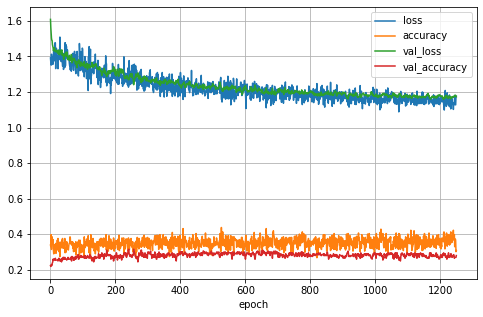

time to execute: 1.89 minutes
Ticker: ['BTC'] returned and average of 0.06 percent over 8.17 days and 53 trades
Started with $5000 and ended with $5129.2

Ticker: ['BTC'] returned and average of 0.48 percent over 8.17 days and 53 trades when setting selling limit
Started with $5000 and ended with $6428.9

percentage correct: 18.87%
Sequence length: 5




std: 0.85
std: 0.85
tickers: ['BTC'], train length: 324, validation length: 195
Accuracy with train data: 43.21
Accuracy with validation data: 29.23


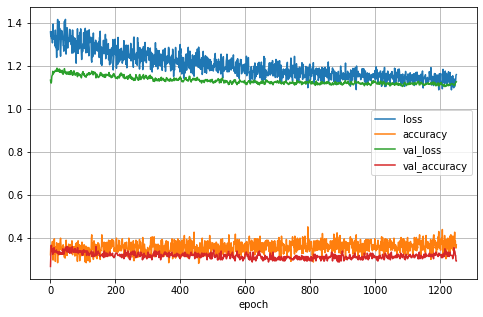

time to execute: 2.04 minutes
Ticker: ['BTC'] returned and average of -0.01 percent over 8.12 days and 74 trades
Started with $5000 and ended with $4953.3

Ticker: ['BTC'] returned and average of 0.35 percent over 8.12 days and 74 trades when setting selling limit
Started with $5000 and ended with $6463.0

percentage correct: 18.92%
Sequence length: 6




std: 0.85
std: 0.85
tickers: ['BTC'], train length: 321, validation length: 194
Accuracy with train data: 35.83
Accuracy with validation data: 31.96


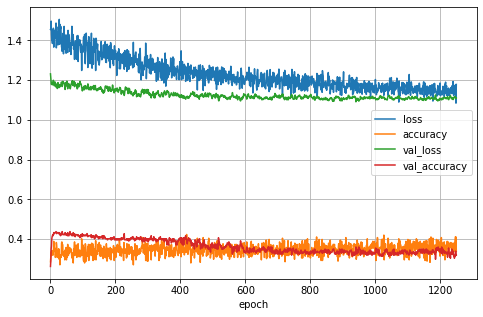

time to execute: 2.25 minutes
Ticker: ['BTC'] returned and average of 0.03 percent over 8.08 days and 67 trades
Started with $5000 and ended with $5048.9

Ticker: ['BTC'] returned and average of 0.46 percent over 8.08 days and 67 trades when setting selling limit
Started with $5000 and ended with $6777.2

percentage correct: 20.9%
Sequence length: 7






In [53]:
# this where I test the models
models = []
ticker = ["BTC"]
SEQ_LEN = 5
for i in range(3):
    start = time.time()
#     SEQ_LEN = 3
    SHIFT = 200
    score,model,predictions,trainX,trainY,trainPercent,validationX,validationY,validationPercent = main(ticker, SEQ_LEN, SHIFT)
    print("time to execute: {} minutes".format(round((time.time()-start)/60,2)))

    models.append(["model:{}, ticker: {}".format(str(i), ticker[0]), model])

    Return = []; times = 0; timesRight = 0; ReturnS = []
    for i, j, k in zip(predictions, validationY, validationPercent):
        if np.argmax(i, axis=0) == 2:
            Return.append(round(k,2))
            if round(k,2) < -0.2:
                k = -0.2
            times += 1
            if j == 2:
                timesRight += 1
            ReturnS.append(k)
    #         print("prediction: {}, actual: {}, and percentage: {}".format(np.argmax(i, axis=0), j, round(k,2)))

    start = 5000; amount = start   
    for i in Return:
        amount = (amount * (i/100)) + amount

    start = 5000; amountS = start   
    for i in ReturnS:
        amountS = (amountS * (i/100)) + amountS

#     print()
    print("Ticker: {} returned and average of {} percent over {} days and {} trades".format(ticker, round(np.average(Return),2), round(len(predictions)/24,2), len(Return)))
    print("Started with ${} and ended with ${}".format(start, round(amount,1)))
    print()
    print("Ticker: {} returned and average of {} percent over {} days and {} trades when setting selling limit".format(ticker, round(np.average(ReturnS),2), round(len(predictions)/24,2), len(ReturnS)))
    print("Started with ${} and ended with ${}".format(start, round(amountS,1)))
    print()
    print("percentage correct: {}%".format(round(100*(timesRight/times),2)))
    print("Sequence length: {}".format(SEQ_LEN))
    print()
    print()
    print() 
    print()
    
    SEQ_LEN += 1

    

In [52]:
round(len(predictions)/24,2)


8.17

In [95]:
models

[['model:0, ticker: CLR',
 ['model:1, ticker: CLR',
 ['model:2, ticker: CLR',
 ['model:3, ticker: CLR',
 ['model:4, ticker: CLR',
 ['model:5, ticker: CLR',
 ['model:6, ticker: CLR',
 ['model:7, ticker: CLR',
 ['model:8, ticker: CLR',
 ['model:9, ticker: CLR',
 ['model:10, ticker: CLR',
 ['model:11, ticker: CLR',
 ['model:12, ticker: CLR',
 ['model:13, ticker: CLR',
 ['model:14, ticker: CLR',
 ['model:0, ticker: EQNR',
 ['model:1, ticker: EQNR',
 ['model:2, ticker: EQNR',
 ['model:3, ticker: EQNR',
 ['model:4, ticker: EQNR',
 ['model:5, ticker: EQNR',
 ['model:6, ticker: EQNR',
 ['model:7, ticker: EQNR',
 ['model:8, ticker: EQNR',
 ['model:9, ticker: EQNR',
 ['model:10, ticker: EQNR',
 ['model:11, ticker: EQNR',
 ['model:12, ticker: EQNR',
 ['model:13, ticker: EQNR',
 ['model:14, ticker: EQNR',
 ['model:0, ticker: MPC',
 ['model:1, ticker: MPC',
 ['model:2, ticker: MPC',
 ['model:3, ticker: MPC',
 ['model:4, ticker: MPC',
 ['model:5, ticker: MPC',
 ['model:6, ticker: MPC',
 ['model:7, t

In [77]:
models[0][0] == 'FNGU'

False

In [103]:
ticker = "NTR"
Models = []
for model in models:
    if ticker in model[0]:
        Models.append(model[1])

In [100]:
Models

In [42]:
Models = []
for row in models:
    Models.append(row[1])

In [43]:
Models

In [93]:
ticker = Tickers[0][0]
print(ticker)
os.listdir(ticker)

CLR


['CLR_model4.h5',
 'CLR_model1.h5',
 'CLR_model5.h5',
 'CLR_model2.h5',
 'CLR_model3.h5']

In [104]:
ticker = Tickers[0][0]
ticker = "NTR"
List = os.listdir(ticker) # dir is your directory path
num = len(List) - 1
num = 1
for model in Models:
    if os.path.isfile(ticker+'/'+ticker+'_model'+str(num)+'.h5') is False:
        model.save(ticker+'/'+ticker+'_model'+str(num)+'.h5')
        num += 1


In [46]:
Return = []; times = 0; timesRight = 0; ReturnS = []
for i, j, k in zip(predictions, validationY, validationPercent):
    if np.argmax(i, axis=0) == 2:
        Return.append(round(k,2))
        if round(k,2) < -2:
            k = -2
        times += 1
        if j == 2:
            timesRight += 1
        ReturnS.append(k)
        print("prediction: {}, actual: {}, and percentage: {}".format(np.argmax(i, axis=0), j, round(k,2)))

start = 5000; amount = start   
for i in Return:
    amount = (amount * (i/100)) + amount

start = 5000; amountS = start   
for i in ReturnS:
    amountS = (amountS * (i/100)) + amountS

print()
print("Ticker: {} returned and average of {} percent over {} days and {} trades".format(tickers, round(np.average(Return),2), len(predictions), len(Return)))
print("Started with ${} and ended with ${}".format(start, round(amount,1)))
print()
print("Ticker: {} returned and average of {} percent over {} days and {} trades when setting selling limit".format(tickers, round(np.average(ReturnS),2), len(predictions), len(ReturnS)))
print("Started with ${} and ended with ${}".format(start, round(amountS,1)))
print()
print("percentage correct: {}%".format(round(100*(timesRight/times),2)))
# print("Sequence length: {}".format(SEQ_LEN))
print()
print()
print() 
print()
        

prediction: 2, actual: 1, and percentage: -2
prediction: 2, actual: 1, and percentage: -2
prediction: 2, actual: 2, and percentage: 2.95
prediction: 2, actual: 2, and percentage: 3.03
prediction: 2, actual: 2, and percentage: 3.82
prediction: 2, actual: 1, and percentage: -2
prediction: 2, actual: 0, and percentage: -0.43
prediction: 2, actual: 0, and percentage: 1.89
prediction: 2, actual: 0, and percentage: -0.92
prediction: 2, actual: 0, and percentage: -0.73
prediction: 2, actual: 2, and percentage: 4.3
prediction: 2, actual: 0, and percentage: -1.69
prediction: 2, actual: 0, and percentage: 0.17
prediction: 2, actual: 0, and percentage: -1.2
prediction: 2, actual: 0, and percentage: -0.81
prediction: 2, actual: 0, and percentage: -0.37
prediction: 2, actual: 0, and percentage: -1.64
prediction: 2, actual: 2, and percentage: 2.97
prediction: 2, actual: 2, and percentage: 2.97
prediction: 2, actual: 0, and percentage: -1.6
prediction: 2, actual: 1, and percentage: -2
prediction: 2, 

In [31]:

ticker = "HIBL"
List = os.listdir(ticker)
List

['HIBL_model9.h5',
 'HIBL_model13.h5',
 'HIBL_model8.h5',
 'HIBL_model12.h5',
 'HIBL_model7.h5',
 'HIBL_model3.h5',
 'HIBL_model2.h5',
 'HIBL_model6.h5',
 'HIBL_model1.h5',
 'HIBL_model5.h5',
 'HIBL_model4.h5',
 'HIBL_model11.h5',
 'HIBL_model15.h5',
 'HIBL_model14.h5',
 'HIBL_model10.h5']

In [116]:

# ticker = tickers[0]
ticker = "NTR"
List = os.listdir(ticker)
for m in List:
    if 'model' in ticker+'/'+m:
        model = load_model(ticker+'/'+m)
    
        predictions = (model.predict(validationX))
        
        
        Return = []; times = 0; timesRight = 0; ReturnS = []
        for i, j, k in zip(predictions, validationY, validationPercent):
            if np.argmax(i, axis=0) == 2:
                Return.append(round(k,2))
                if round(k,2) < -2:
                    k = -2
                times += 1
                if j == 2:
                    timesRight += 1
                ReturnS.append(k)
        #         print("prediction: {}, actual: {}, and percentage: {}".format(np.argmax(i, axis=0), j, round(k,2)))

        start = 5000; amount = start   
        for i in Return:
            amount = (amount * (i/100)) + amount

        start = 5000; amountS = start   
        for i in ReturnS:
            amountS = (amountS * (i/100)) + amountS

        print()
        print("results for model: {}".format(m))
        print("Ticker: {} returned and average of {} percent over {} days and {} trades".format(ticker, round(np.average(Return),2), len(predictions), len(Return)))
        print("Started with ${} and ended with ${}".format(start, round(amount,1)))
        print()
        print("Ticker: {} returned and average of {} percent over {} days and {} trades when setting selling limit".format(ticker, round(np.average(ReturnS),2), len(predictions), len(ReturnS)))
        print("Started with ${} and ended with ${}".format(start, round(amountS,1)))
        print()
        print("percentage correct: {}%".format(round(100*(timesRight/times),2)))
        # print("Sequence length: {}".format(SEQ_LEN))
        print()
        print()
        print() 
        print()
        
        



results for model: NTR_model4.h5
Ticker: NTR returned and average of 0.48 percent over 73 days and 19 trades
Started with $5000 and ended with $5463.0

Ticker: NTR returned and average of 0.5 percent over 73 days and 19 trades when setting selling limit
Started with $5000 and ended with $5480.2

percentage correct: 42.11%





results for model: NTR_model12.h5
Ticker: NTR returned and average of 0.56 percent over 73 days and 16 trades
Started with $5000 and ended with $5441.2

Ticker: NTR returned and average of 0.83 percent over 73 days and 16 trades when setting selling limit
Started with $5000 and ended with $5701.0

percentage correct: 43.75%





results for model: NTR_model8.h5
Ticker: NTR returned and average of 0.16 percent over 73 days and 16 trades
Started with $5000 and ended with $5115.6

Ticker: NTR returned and average of 0.25 percent over 73 days and 16 trades when setting selling limit
Started with $5000 and ended with $5193.0

percentage correct: 37.5%





results fo

In [26]:
trainX.shape

(363, 3, 6)

In [15]:
Tickers = [
    ["UPRO"],["SPXL"],["UPRO"],["UDOW"],["GUSH"],["TMF"],
    ["URTY"],["DFEN"],["NAIL"],["CURE"],["EDC"],["WEBL"],
    ["DRN"],["RETL"],["INDL"],["HIBL"],["MIDU"],["TPOR"],
    ["DUSL"],["UMDD"],["WANT"],["EURL"],["KORU"],["UBOT"],
    ["UTSL"],["PILL"],["TYD"],["MEXX"],["BNKU"],["BULZ"],
    ["FNGU"],["NRGU"],["OILU"]
]

In [18]:
Tickers = [
    ["UPRO"],["SPXL"],["UPRO"],["UDOW"],["GUSH"],["TMF"],
    ["URTY"],["DFEN"],["NAIL"],["CURE"],["EDC"],["WEBL"],
    ["DRN"],["RETL"],["INDL"],["HIBL"],["MIDU"],["TPOR"],
    ["DUSL"],["UMDD"],["WANT"],["EURL"],["KORU"],["UBOT"],
    ["UTSL"],["PILL"],["MEXX"],["BNKU"],
    ["FNGU"],["GDXU"],["NRGU"]
]

In [19]:

for tickers in Tickers:
    SHIFT = 75
    SEQ_LEN = 2
    trainX, trainY, trainPercent = trainData(SEQ_LEN, SHIFT, tickers)
    validationX, validationY, validationPercent = testData(SEQ_LEN, SHIFT, tickers)
    print("tickers: {}, train length: {}, validation length: {}".format(tickers, len(trainX), len(validationX)))
    print()

std: 1.32
std: 1.32
tickers: ['UPRO'], train length: 435, validation length: 74

std: 1.3
std: 1.3
tickers: ['SPXL'], train length: 432, validation length: 74

std: 1.32
std: 1.32
tickers: ['UPRO'], train length: 435, validation length: 74

std: 1.33
std: 1.33
tickers: ['UDOW'], train length: 423, validation length: 74

std: 2.94
std: 2.94
tickers: ['GUSH'], train length: 525, validation length: 74

std: 1.09
std: 1.09
tickers: ['TMF'], train length: 414, validation length: 74

std: 1.92
std: 1.92
tickers: ['URTY'], train length: 522, validation length: 74

std: 2.01
std: 2.01
tickers: ['DFEN'], train length: 474, validation length: 74

std: 2.68
std: 2.68
tickers: ['NAIL'], train length: 492, validation length: 74

std: 1.4
std: 1.4
tickers: ['CURE'], train length: 456, validation length: 74

std: 1.05
std: 1.05
tickers: ['EDC'], train length: 537, validation length: 74

std: 2.19
std: 2.19
tickers: ['WEBL'], train length: 318, validation length: 74

std: 1.8
std: 1.8
tickers: ['DRN']